# Part 1: CNN Model Baseline - Performance & Testing

## Overview
In this notebook, we will:
1. Train a simple CNN model on an ADAS (Advanced Driver Assistance Systems) dataset
2. Log key performance metrics: accuracy, inference time, model size, parameters
3. Understand the relationship between model complexity and performance
4. Establish a baseline for robustness testing

## Key Concepts
- **Time Complexity**: How inference time grows with input size
- **Model Size vs Performance**: The tradeoff between model complexity and accuracy
- **Baseline Metrics**: Essential measurements for ML model evaluation

## Step 1: Import Libraries & Setup

In [33]:
import os
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# PyTorch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision.models import resnet18

# Progress bar
from tqdm import tqdm

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

print("✅ All libraries imported successfully")

✅ All libraries imported successfully


## Step 2: Device Configuration

In [34]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("Running on CPU - training may be slower")

Using device: cpu
Running on CPU - training may be slower


## Step 3: Load Dataset

In [35]:
# Dataset paths
DATASET_PATH = r"C:\Users\Lucifer\python_workspace\BITS\AI_Quality_Engineering\dataset"
TRAIN_PATH = os.path.join(DATASET_PATH, "train")
VAL_PATH = os.path.join(DATASET_PATH, "val")
TEST_PATH = os.path.join(DATASET_PATH, "test")

print(f"📁 Dataset path: {DATASET_PATH}")

📁 Dataset path: C:\Users\Lucifer\python_workspace\BITS\AI_Quality_Engineering\dataset


In [36]:
# Data transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Resize to fixed size
    transforms.ToTensor(),           # Convert to tensor (0-1 range)
    transforms.Normalize(            # Normalize with ImageNet stats
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

print("✅ Data transformations defined")

✅ Data transformations defined


In [37]:
# Load datasets
print("Loading datasets...")
train_dataset = ImageFolder(TRAIN_PATH, transform=transform)
val_dataset = ImageFolder(VAL_PATH, transform=transform)
test_dataset = ImageFolder(TEST_PATH, transform=transform)

print(f"✅ Train samples: {len(train_dataset)}")
print(f"✅ Val samples: {len(val_dataset)}")
print(f"✅ Test samples: {len(test_dataset)}")

# Class names
class_names = train_dataset.classes
num_classes = len(class_names)
print(f"\n📚 Classes ({num_classes}): {', '.join(class_names)}")

Loading datasets...
✅ Train samples: 796
✅ Val samples: 234
✅ Test samples: 117

📚 Classes (7): animal, name_board, pedestrian, pothole, road_sign, speed_breaker, vehicle


In [38]:
# Data loaders
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

print(f"✅ Data loaders created with batch size: {BATCH_SIZE}")

✅ Data loaders created with batch size: 16


## Step 4: Create Model Architecture

In [39]:
# Create model
model = resnet18(pretrained=True)  # Use pre-trained weights
model.fc = nn.Linear(model.fc.in_features, num_classes)  # Modify final layer
model = model.to(device)

print("✅ ResNet-18 model created")
print(f"   Modified final layer to output {num_classes} classes")

✅ ResNet-18 model created
   Modified final layer to output 7 classes


### Architecture Overview

We use **ResNet-18**, a pre-trained convolutional neural network:
- Input size: 128×128×3 (RGB images)
- Output: 7 classes (ADAS categories)
- Pre-trained on ImageNet for better feature extraction
- Lightweight: good balance between accuracy and speed

## Step 5: Analyze Model Complexity

In [40]:
def count_parameters(model):
    """Count total trainable parameters"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def get_model_size_mb(model):
    """Get model size in MB"""
    torch.save(model.state_dict(), "temp_model.pth")
    size_mb = os.path.getsize("temp_model.pth") / (1024 * 1024)
    os.remove("temp_model.pth")
    return size_mb

total_params = count_parameters(model)
model_size = get_model_size_mb(model)

print(f"📊 Model Statistics:")
print(f"  Total Parameters: {total_params:,}")
print(f"  Model Size: {model_size:.2f} MB")
print(f"  Average parameter size: {(model_size * 1024 * 1024 / total_params):.2f} bytes")

# Store for later
metrics = {
    'total_parameters': total_params,
    'model_size_mb': model_size
}

📊 Model Statistics:
  Total Parameters: 11,180,103
  Model Size: 42.72 MB
  Average parameter size: 4.01 bytes


## Step 6: Setup Training Configuration

In [41]:
# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

print("✅ Loss function: CrossEntropyLoss")
print("✅ Optimizer: Adam (lr=0.01)")

✅ Loss function: CrossEntropyLoss
✅ Optimizer: Adam (lr=0.01)


## Step 7: Define Training & Evaluation Functions

In [42]:
def train_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    start_time = time.time()
    
    for images, labels in tqdm(loader, desc="Training", leave=False):
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    epoch_time = time.time() - start_time
    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy, epoch_time

print("✅ train_epoch() defined")

✅ train_epoch() defined


In [43]:
def evaluate(model, loader, criterion, device):
    """Evaluate on validation/test set"""
    model.eval()
    correct = 0
    total = 0
    running_loss = 0.0
    
    start_time = time.time()
    
    with torch.no_grad():
        for images, labels in tqdm(loader, desc="Evaluating", leave=False):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    eval_time = time.time() - start_time
    avg_loss = running_loss / len(loader)
    accuracy = 100 * correct / total
    
    return avg_loss, accuracy, eval_time

print("✅ evaluate() defined")

✅ evaluate() defined


## Step 8: Train the Model

In [44]:
NUM_EPOCHS = 30
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': [],
    'train_time': [],
    'val_time': []
}

print(f"Starting training for {NUM_EPOCHS} epochs...\n")
overall_start = time.time()

for epoch in range(NUM_EPOCHS):
    # Train
    train_loss, train_acc, train_time = train_epoch(
        model, train_loader, criterion, optimizer, device
    )
    
    # Validate
    val_loss, val_acc, val_time = evaluate(
        model, val_loader, criterion, device
    )
    
    # Store history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    history['train_time'].append(train_time)
    history['val_time'].append(val_time)
    
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")
    print(f"  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"  Val Loss:   {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print(f"  Time: Train {train_time:.2f}s | Val {val_time:.2f}s\n")

overall_time = time.time() - overall_start
print(f"✅ Training completed in {overall_time:.2f} seconds")

metrics['total_training_time'] = overall_time

Starting training for 30 epochs...



Training:   0%|          | 0/50 [00:00<?, ?it/s]

Epoch [1/30]
  Train Loss: 2.1507 | Train Acc: 54.77%
  Val Loss:   4.8301 | Val Acc: 62.39%
  Time: Train 47.85s | Val 5.40s



Epoch [2/30]
  Train Loss: 1.2410 | Train Acc: 67.09%
  Val Loss:   1.3276 | Val Acc: 66.24%
  Time: Train 46.61s | Val 5.08s



Epoch [3/30]
  Train Loss: 1.3156 | Train Acc: 68.84%
  Val Loss:   1.5154 | Val Acc: 70.94%
  Time: Train 47.09s | Val 6.20s



Epoch [4/30]
  Train Loss: 0.9614 | Train Acc: 71.61%
  Val Loss:   0.9685 | Val Acc: 73.50%
  Time: Train 48.80s | Val 5.56s



Epoch [5/30]
  Train Loss: 0.9930 | Train Acc: 69.72%
  Val Loss:   1.0627 | Val Acc: 72.22%
  Time: Train 49.76s | Val 5.64s



Epoch [6/30]
  Train Loss: 0.8948 | Train Acc: 72.36%
  Val Loss:   0.9278 | Val Acc: 74.79%
  Time: Train 49.72s | Val 5.75s



Epoch [7/30]
  Train Loss: 0.7872 | Train Acc: 75.75%
  Val Loss:   1.2337 | Val Acc: 73.50%
  Time: Train 49.08s | Val 5.70s



Epoch [8/30]
  Train Loss: 0.7112 | Train Acc: 78.02%
  Val Loss:   0.7320 | Val Acc: 79.49%
  Time: Train 49.58s | Val 5.39s



Epoch [9/30]
  Train Loss: 0.6794 | Train Acc: 79.90%
  Val Loss:   1.1281 | Val Acc: 79.91%
  Time: Train 49.57s | Val 5.37s



Epoch [10/30]
  Train Loss: 0.6152 | Train Acc: 81.16%
  Val Loss:   0.5545 | Val Acc: 82.48%
  Time: Train 49.40s | Val 5.46s



Epoch [11/30]
  Train Loss: 0.5554 | Train Acc: 81.28%
  Val Loss:   0.6139 | Val Acc: 81.20%
  Time: Train 49.27s | Val 5.45s



Epoch [12/30]
  Train Loss: 0.5424 | Train Acc: 81.91%
  Val Loss:   0.8213 | Val Acc: 72.65%
  Time: Train 49.89s | Val 5.58s



Epoch [13/30]
  Train Loss: 0.5092 | Train Acc: 82.79%
  Val Loss:   0.5372 | Val Acc: 82.05%
  Time: Train 49.37s | Val 5.43s



Epoch [14/30]
  Train Loss: 0.4592 | Train Acc: 84.17%
  Val Loss:   0.8082 | Val Acc: 78.63%
  Time: Train 50.58s | Val 5.46s



Epoch [15/30]
  Train Loss: 0.4327 | Train Acc: 83.54%
  Val Loss:   0.7660 | Val Acc: 76.92%
  Time: Train 49.61s | Val 5.46s



Epoch [16/30]
  Train Loss: 0.4857 | Train Acc: 81.78%
  Val Loss:   0.4716 | Val Acc: 80.34%
  Time: Train 50.53s | Val 5.38s



Epoch [17/30]
  Train Loss: 0.4180 | Train Acc: 83.17%
  Val Loss:   0.4708 | Val Acc: 85.04%
  Time: Train 49.12s | Val 5.40s



Epoch [18/30]
  Train Loss: 0.3666 | Train Acc: 86.68%
  Val Loss:   0.3985 | Val Acc: 85.90%
  Time: Train 49.42s | Val 5.70s



Epoch [19/30]
  Train Loss: 0.3654 | Train Acc: 86.31%
  Val Loss:   0.8622 | Val Acc: 80.34%
  Time: Train 49.20s | Val 5.53s



Epoch [20/30]
  Train Loss: 0.3244 | Train Acc: 89.45%
  Val Loss:   0.3766 | Val Acc: 87.18%
  Time: Train 49.17s | Val 5.33s



Epoch [21/30]
  Train Loss: 0.3381 | Train Acc: 87.81%
  Val Loss:   0.6464 | Val Acc: 80.77%
  Time: Train 49.05s | Val 5.44s



Epoch [22/30]
  Train Loss: 0.3613 | Train Acc: 86.93%
  Val Loss:   0.5741 | Val Acc: 81.20%
  Time: Train 49.52s | Val 5.35s



Epoch [23/30]
  Train Loss: 0.2925 | Train Acc: 89.32%
  Val Loss:   0.3538 | Val Acc: 90.60%
  Time: Train 49.42s | Val 5.46s



Epoch [24/30]
  Train Loss: 0.2389 | Train Acc: 91.71%
  Val Loss:   0.3740 | Val Acc: 88.46%
  Time: Train 49.83s | Val 5.52s



Epoch [25/30]
  Train Loss: 0.2285 | Train Acc: 91.96%
  Val Loss:   0.8973 | Val Acc: 77.78%
  Time: Train 49.88s | Val 5.33s



Epoch [26/30]
  Train Loss: 0.2467 | Train Acc: 91.46%
  Val Loss:   0.7778 | Val Acc: 76.50%
  Time: Train 51.95s | Val 6.49s



Epoch [27/30]
  Train Loss: 0.1825 | Train Acc: 93.22%
  Val Loss:   0.2973 | Val Acc: 89.32%
  Time: Train 55.54s | Val 5.86s



Epoch [28/30]
  Train Loss: 0.1719 | Train Acc: 94.60%
  Val Loss:   0.3968 | Val Acc: 88.03%
  Time: Train 51.80s | Val 5.63s



Epoch [29/30]
  Train Loss: 0.1826 | Train Acc: 93.09%
  Val Loss:   0.2734 | Val Acc: 92.31%
  Time: Train 52.27s | Val 5.56s



Epoch [30/30]
  Train Loss: 0.2028 | Train Acc: 93.59%
  Val Loss:   0.4456 | Val Acc: 82.91%
  Time: Train 52.32s | Val 5.61s

✅ Training completed in 1661.81 seconds


## Step 9: Test Evaluation

In [45]:
# Test evaluation
test_loss, test_acc, test_time = evaluate(model, test_loader, criterion, device)

# Calculate per-image inference time
num_test_samples = len(test_dataset)
avg_inference_time = (test_time / num_test_samples) * 1000  # in milliseconds

print("\n" + "="*60)
print("📊 TEST SET PERFORMANCE")
print("="*60)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.2f}%")
print(f"Total Inference Time: {test_time:.2f} seconds")
print(f"Avg Inference Time per Image: {avg_inference_time:.4f} ms")
print("="*60 + "\n")

# Update metrics
metrics['test_accuracy'] = test_acc
metrics['total_inference_time'] = test_time
metrics['avg_inference_time_ms'] = avg_inference_time


📊 TEST SET PERFORMANCE
Test Loss: 0.4070
Test Accuracy: 82.91%
Total Inference Time: 3.23 seconds
Avg Inference Time per Image: 27.5784 ms



## Step 10: Visualize Training History

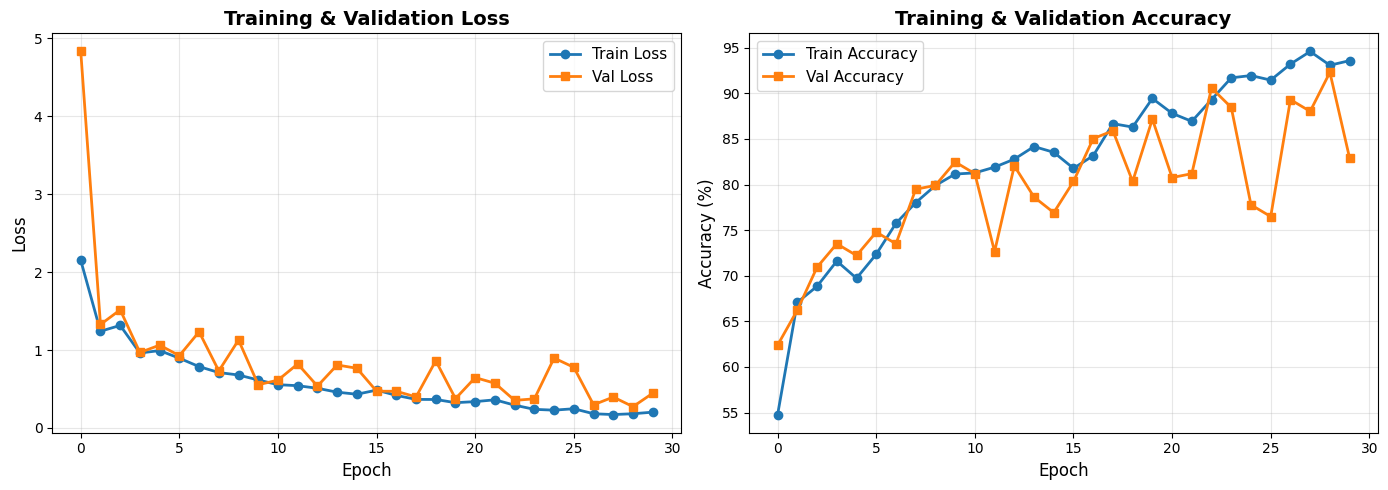

✅ Training curves saved as 'training_curves.png'


In [46]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(history['train_loss'], label='Train Loss', marker='o', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', marker='s', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(history['train_acc'], label='Train Accuracy', marker='o', linewidth=2)
axes[1].plot(history['val_acc'], label='Val Accuracy', marker='s', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Accuracy (%)', fontsize=12)
axes[1].set_title('Training & Validation Accuracy', fontsize=14, fontweight='bold')
axes[1].legend(fontsize=11)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ Training curves saved as 'training_curves.png'")

## Step 11: Final Summary Report

In [47]:
print("\n" + "="*70)
print("🎯 BASELINE MODEL PERFORMANCE REPORT")
print("="*70)

print("\n📈 Accuracy Metrics:")
print(f"  Train Accuracy (final epoch): {history['train_acc'][-1]:.2f}%")
print(f"  Val Accuracy (final epoch):   {history['val_acc'][-1]:.2f}%")
print(f"  Test Accuracy:                {metrics['test_accuracy']:.2f}%")

print("\n⏱️  Time Metrics:")
print(f"  Total Training Time:          {metrics['total_training_time']:.2f} seconds")
print(f"  Total Inference Time:         {metrics['total_inference_time']:.2f} seconds")
print(f"  Avg Inference per Image:      {metrics['avg_inference_time_ms']:.4f} ms")

print("\n📊 Model Complexity:")
print(f"  Total Parameters:             {metrics['total_parameters']:,}")
print(f"  Model Size:                   {metrics['model_size_mb']:.2f} MB")

# Analysis
train_val_gap = history['train_acc'][-1] - history['val_acc'][-1]

print("\n🔑 Key Observations:")
print(f"  Train-Val Accuracy Gap:       {train_val_gap:.2f}%")

if train_val_gap > 10:
    print("  ⚠️  High overfitting detected (Train >> Val accuracy)")
elif train_val_gap > 5:
    print("  ⚠️  Some overfitting detected")
else:
    print("  ✅ Good generalization (Train and Val accuracy are close)")

print("\n💡 This baseline will be used for:")
print("  • Overfitting detection in Part 2")
print("  • Robustness testing in Part 3")
print("  • Comparing with regularization techniques")

print("\n" + "="*70)


🎯 BASELINE MODEL PERFORMANCE REPORT

📈 Accuracy Metrics:
  Train Accuracy (final epoch): 93.59%
  Val Accuracy (final epoch):   82.91%
  Test Accuracy:                82.91%

⏱️  Time Metrics:
  Total Training Time:          1661.81 seconds
  Total Inference Time:         3.23 seconds
  Avg Inference per Image:      27.5784 ms

📊 Model Complexity:
  Total Parameters:             11,180,103
  Model Size:                   42.72 MB

🔑 Key Observations:
  Train-Val Accuracy Gap:       10.69%
  ⚠️  High overfitting detected (Train >> Val accuracy)

💡 This baseline will be used for:
  • Overfitting detection in Part 2
  • Robustness testing in Part 3
  • Comparing with regularization techniques

